In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import reliability
from reliability.Fitters import Fit_Weibull_2P
import scipy.optimize as optimization
sys.path.append('../../..')

import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

In [13]:
%matplotlib notebook

The next cell has parameters that might change from crystal to crystal

In [14]:
# Loading in the compressed data
Segmentname = 'Segments1'
Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# Histogram accumulation
accumlist = [12,13,14,15,16,17,18,19] # all

# Parameters for binning
Z2minforhist = 0.0
Z2maxforhist = .011
Z2offset = 0.0001
nbins_max = 8
levels = 3

Segments1_compr_flat_filt.npz


In [15]:
# # Loading in the compressed data
# Segmentname = 'Segments2'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .25
# Z2offset = 0.001
# nbins_max = 8
# levels = 3

In [16]:
# Derivative names
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments1_compr_flat_filt_roughness.jpg
20
2019-07-02/case2.0 (calibration)


In [17]:
# Histogram accumulation
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
print('Using levels =', levels, 'for uncertainty analysis')


Accumulating segments [12, 13, 14, 15, 16, 17, 18, 19]
Plotting segments [12, 13, 14, 15, 16, 17, 18, 19]
Z2 ranging from 0.0 to 0.011
Max number of bins specified is 8
Sturges rule says maxbins = 10
Using nbins =  8
Using levels = 3 for uncertainty analysis


In [18]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# First-guess for Weibull fitting (sigma2W, etaW)
x0 = np.array([.1,.9])

# This suppresses warnings when lots of graphics windows are open
import matplotlib
matplotlib.rc('figure', max_open_warning = 0)

# This is for when we want to show or suppress intermediate graphics and other output
Show_intermediate_graphics = False

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)

    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Reporting
        print('')
        print('****Working on segment', isegment)
        
        # Graph the surface
        if Show_intermediate_graphics:
            fig1 = plt.figure()
            ax = fig1.add_subplot(111, projection='3d')
            ax.plot_surface(xgrid, ygrid, sollast)
            title = Flattenedfilename+' #'+str(isegment)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.set_title(title)
            ax.view_init(azim=-120,elev=22)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # This is for calculating the errors in fitting (and graphing)
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)

        # Graph the probability
        if Show_intermediate_graphics:
            plt.figure()
            plt.semilogy(bins, counts, 'ok')
            plt.semilogy(bins, countsplus, '+k')
            plt.semilogy(bins, countsminus,'+k')
            plt.title(title)
            plt.xlabel(r'$Z^{2}$')
            plt.ylabel(r'$\rho$')
            plt.grid(True)

        # Eliminate entries greater than a threshold (not sure if this is necessary)
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])

        # Attempt a best-fit based on the raw data
        analysis = Fit_Weibull_2P(failures=Z2flat_new,show_probability_plot=False)
        etaW = analysis.beta; #print('analysis.beta=',analysis.beta)
        sigma2W = analysis.alpha; #print('analysis.alpha=',analysis.alpha)
        sigmaW = np.sqrt(sigma2W)
        print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)
        
        # Attempt a best-fit based on the bins
        errors = np.log(countsplus/counts); #print(errors)
        solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
        etaW = solution[1]
        sigma2W = solution[0]
        sigmaW = np.sqrt(sigma2W)
        print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)
        
        # Graph the best-fit probability
        myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
        if Show_intermediate_graphics:
            plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
            plt.legend()
        
    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

Original =  760
4 0 190 [56 41 27 17 22  4  8]
4 1 190 [65 33 28 18  9  7  5]
4 2 190 [54 44 28 14 11 14  5]
4 3 190 [53 44 27 16 16  9  7]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.00478903988629203
statsigma =  0.06920288929150308
Original =  760
4 0 190 [58 32 23 19 16  9  7]
4 1 190 [44 45 28 20 13  8  9]
4 2 190 [47 36 25 21 25  9  7]
4 3 190 [43 41 29 27 12  8  6]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.005110302824116748
statsigma =  0.07148638208859606
Original =  760
4 0 190 [59 31 30 22 16  8  9]
4 1 190 [48 43 25 18 16 15  8]
4 2 190 [69 47 20 21  9  9  7]
4 3 190 [72 34 32 18 16  4  2]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.004120887295110829
statsigma =  0.06419413754472311
Original =  760
4 0 190 [49 39 28 18 15 12  7]
4 1 190 [67 38 31 14  8  6  6]
4 2 190 [69 37 32 13 10 10  4]
4 3 190 [59 35 26 16 17 11 11]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.004397140382476393
statsigma =  0.06631093712560843
O

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error  Lower CI  Upper CI
Parameter                                                    
Alpha            0.004207        0.000161  0.003903  0.004534
Beta             1.135914        0.038964  1.062056  1.214908
Log-Likelihood: 2632.93609871173
Based on raw data: sigmaW, etaW =  0.06486036525667675 1.1359139613415161
Based on bins: sigmaW, etaW =  0.071985739163253 1.0073692740091473
Original =  760
4 0 190 [38 47 27 20 17 15  6]
4 1 190 [38 45 25 25 11 15  3]
4 2 190 [49 40 36 10 13 12 10]
4 3 190 [51 44 29 14  9 10  8]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.005252799207145172
statsigma =  0.07247619752129089

****Working on segment 19
std dev of height =  0.11019380334841516
integral =  0.0013322981366459628
[166.34691064 183.30969153 110.01479336  53.17855354  42.35228103
  47.70881197  19.83448569]
Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error  Lower CI  Up

Original =  760
4 0 190 [38 47 27 20 17 15  6]
4 1 190 [38 45 25 25 11 15  3]
4 2 190 [49 40 36 10 13 12 10]
4 3 190 [51 44 29 14  9 10  8]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.005252799207145172
statsigma =  0.07247619752129089
integral =  0.0013322981366459628


<IPython.core.display.Javascript object>


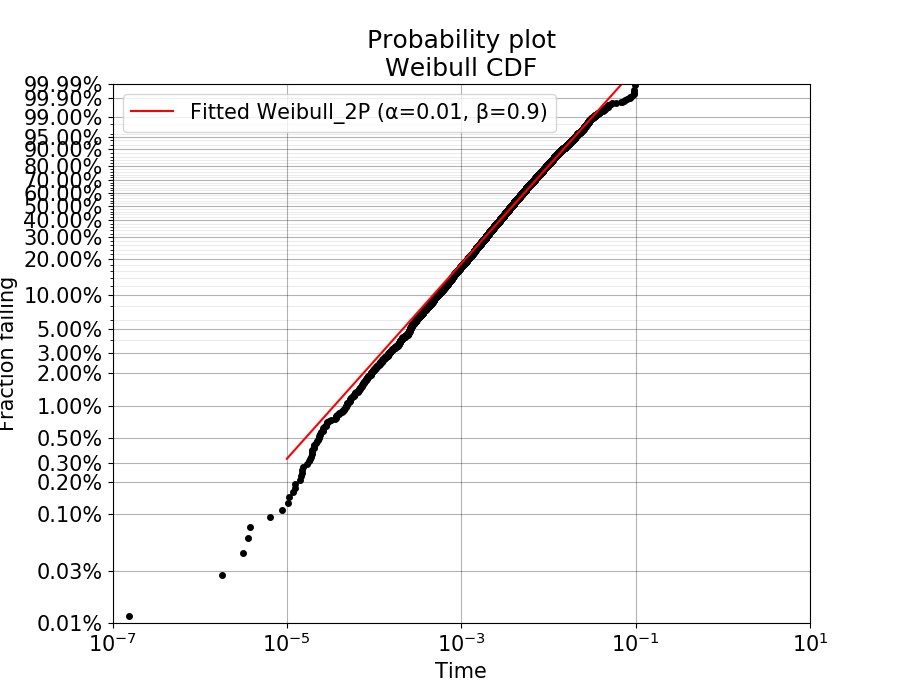

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error  Lower CI  Upper CI
Parameter                                                    
Alpha            0.005847        0.000088  0.005677  0.006022
Beta             0.898958        0.008759  0.881953  0.916291
Log-Likelihood: 24916.83654293343
analysis.beta= 0.8989580813763447
analysis.alpha= 0.005846771168231508
Based on raw data: sigmaW, etaW =  0.07646418225699866 0.8989580813763447


In [19]:
# Sum up the accumulated information
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
Z2flat_new = np.squeeze(Z2flat_total)

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; #print(countsminus)

# Attempt a best-fit based on the raw data
plt.figure()
analysis = Fit_Weibull_2P(failures=Z2flat_new)
etaW = analysis.beta; print('analysis.beta=',analysis.beta)
sigma2W = analysis.alpha; print('analysis.alpha=',analysis.alpha)
sigmaW = np.sqrt(sigma2W)
print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)

In [20]:
# Attempt a best-fit based on the bins
errors = np.log(countsplus/counts); #print(errors)
solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
etaW = solution[1]
sigma2W = solution[0]
sigmaW = np.sqrt(sigma2W)
print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)

Based on bins: sigmaW, etaW =  0.06313335772631358 1.11852890380602


<IPython.core.display.Javascript object>


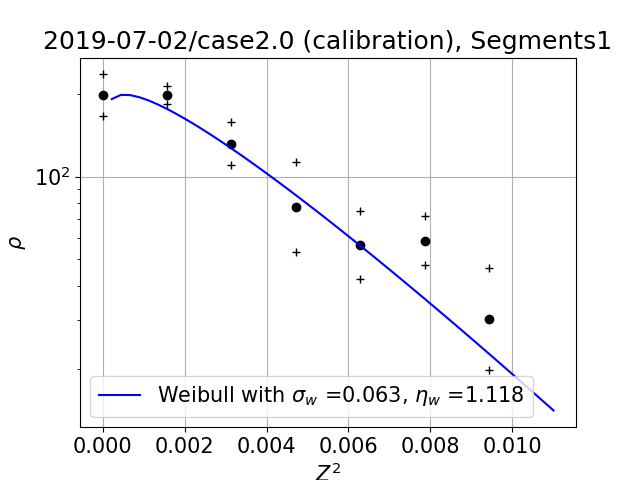

In [21]:
# Graph the probability
plt.figure()
fontsize = 15
plt.rcParams.update({'font.size': fontsize})
plt.semilogy(bins, counts, 'ok')
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder + ', ' + Segmentname)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b', \
             label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ', $\eta_w$ =' + str(etaW)[0:5])
plt.legend(fontsize=fontsize)

In [22]:
# Save the roughness figure
plt.savefig(Roughnessfilename)